## 导入需要的库

In [58]:

import sys
import numpy as np
sys.path.append("C:\\Users\\RS\\VSCode\\matchedfiltermethod")

from matplotlib import pyplot as plt # type: ignore
import matplotlib.cm as cm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from MatchedFilter import matched_filter as mf
from MatchedFilter import generate_uas as gu
from MyFunctions import needed_function as nf
from MyFunctions import radiance_lut as rl


## 必要的函数



In [89]:
def profile_matched_filter(base_array, data_array: np.array, unit_absorption_spectrum: np.array) :
    # 直接通过背景光谱和目标光谱拟合甲烷浓度增强结果
    background_spectrum = base_array
    target_spectrum = background_spectrum*unit_absorption_spectrum
    concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None) 
    return concentration[0]


# def profile_matched_filter_ML(base_array, data_array: np.array,unit_absorption_spectrum: np.array) :
#     # 直接通过背景光谱和目标光谱拟合甲烷浓度增强结果
#     background_spectrum = base_array
#     target_spectrum = background_spectrum*unit_absorption_spectrum[0]
#     concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None) 

#     if concentration[0] > 4000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[1]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 4000
#     if concentration[0] > 8000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[2]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 8000
#     if concentration[0] > 12000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[3]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 12000
#     if concentration[0] > 16000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[4]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 16000
#     if concentration[0] > 20000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[5]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 20000
#     if concentration[0] > 24000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[6]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 24000
#     if concentration[0] > 28000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[7]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 28000
#     if concentration[0] > 32000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[8]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 32000
    
    
#     return concentration[0]


def profile_matched_filter_ML(base_array, data_array: np.array,unit_absorption_spectrum: np.array) :
    # 直接通过背景光谱和目标光谱拟合甲烷浓度增强结果
    background_spectrum = base_array
    target_spectrum = background_spectrum*unit_absorption_spectrum[0]
    concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None) 

    threshold = 4000
    if concentration[0] > threshold and threshold < 33000:
        background_spectrum = background_spectrum + 4000*target_spectrum
        target_spectrum = background_spectrum*unit_absorption_spectrum[threshold//4000]
        concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
        concentration[0] = concentration[0] + threshold
     
    return concentration[0]


def matched_filter_with_fixed_bg(base_array, data_array: np.array, unit_absorption_spectrum: np.array) :
    # 获取数据 波段 行数 列数 信息， 初始化浓度矩阵
    bands,rows,cols = data_array.shape
    concentration = np.zeros((rows,cols))
    
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱，再计算目标光谱与背景光谱的差值
    background_spectrum = base_array
    target_spectrum = background_spectrum*unit_absorption_spectrum
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]

    # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
    d_covariance = radiancediff_with_back
    covariance = np.zeros((bands,bands))
    for i in range(rows):
        for j in range(cols):
            covariance += np.outer(d_covariance[:,i,j], d_covariance[:,i,j])
    covariance /= rows*cols
    covariance_inverse = np.linalg.pinv(covariance)
    
    # 计算每个像素的甲烷浓度增强结果
    for i in range(rows):
        for j in range(cols):
            up = radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum
            down = target_spectrum.T @ covariance_inverse @ target_spectrum
            concentration[i,j] = up / down
    
    return concentration


def ML_matched_filter_with_fixed_bg(base_array, data_array: np.array, unit_absorption_spectrum: np.array) :
    # 获取数据 波段 行数 列数 信息， 初始化浓度矩阵
    bands,rows,cols = data_array.shape
    concentration = np.zeros((rows,cols))
    
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱，再计算目标光谱与背景光谱的差值
    background_spectrum = base_array
    target_spectrum = background_spectrum*unit_absorption_spectrum[0]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    
    # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
    d_covariance = radiancediff_with_back
    covariance = np.zeros((bands,bands))
    for i in range(rows):
        for j in range(cols):
            covariance += np.outer(d_covariance[:,i,j], d_covariance[:,i,j])
    covariance /= rows*cols
    covariance_inverse = np.linalg.inv(covariance)
    
    # 计算每个像素的甲烷浓度增强结果
    for i in range(rows):
        for j in range(cols):
            up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
            down = target_spectrum.T @ covariance_inverse @ target_spectrum
            concentration[i,j] = up / down
            
    # 对于浓度增强大于一定值的像素，使用分层算法进行计算
    background_spectrum = background_spectrum + 4000*target_spectrum
    target_spectrum = background_spectrum*unit_absorption_spectrum[1]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i,j] > 4000:
                up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i,j] = up / down + 4000
    
    # 对于浓度增强大于一定值的像素，使用分层算法进行计算
    background_spectrum = background_spectrum + 4000*target_spectrum
    target_spectrum = background_spectrum*unit_absorption_spectrum[2]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i,j] > 8000:
                up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i,j] = up / down + 8000
    
    background_spectrum = background_spectrum + 4000*target_spectrum
    target_spectrum = background_spectrum*unit_absorption_spectrum[3]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i,j] > 12000:
                up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i,j] = up / down + 12000
    
    background_spectrum = background_spectrum + 4000*target_spectrum
    target_spectrum = background_spectrum*unit_absorption_spectrum[4]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i,j] > 16000:
                up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i,j] = up / down + 16000
    
    return concentration


def image_simulation(plume, lower_wavelength, upper_wavelength, row_num, col_num,noise_level):
    # Load the simulated emit radiance spectrum
    total_bands,lut = rl.load_lookup_table("C:\\Users\\RS\\VSCode\matchedfiltermethod\\MyData\\enhanced_radiance\\AHSI_rad_lookup_table.npz")
    
    bands,unenhanced_radiance = rl.lookup_spectrum(0,total_bands,lut,lower_wavelength,upper_wavelength)
    # Set the shape of the image that want to simulate
    band_num = len(bands)
    simulated_image = np.zeros([band_num, row_num, col_num])
    # Generate the universal radiance cube image
    for i in range(row_num) :
        for j in range(col_num) :
            if plume[i,j] > 0:
                _,enhanced_radiance = rl.lookup_spectrum(plume[i,j],total_bands,lut,lower_wavelength,upper_wavelength)
                simulated_image[:,i,j] = enhanced_radiance
            else:
                simulated_image[:,i,j] = unenhanced_radiance
    # 为每个波段添加 1% 的高斯噪声
    noise_std = noise_level * simulated_image  # 噪声的标准差为辐亮度的 1%
    noise = np.random.normal(0, noise_std)
    simulated_noisy_image = simulated_image + noise 
  
    return simulated_noisy_image


def enhancement_2perc(enhancement):
    np.random.seed(42)  
    matrix_size = 100
    indices = np.random.choice(matrix_size * matrix_size, 200, replace=False)
    plume = np.zeros((matrix_size, matrix_size))
    np.put(plume, indices, enhancement)
    
    # 选取剩余的像素点作为未增强的像素点,并将选取的像素点转换为行列索引，分别是增强和未增强的像素点
    all_indices = np.arange(plume.size)
    unenhanced_indices = np.setdiff1d(all_indices, indices)
    enhanced_mask = np.unravel_index(indices, (matrix_size, matrix_size))
    unenhanced_mask = np.unravel_index(unenhanced_indices, (matrix_size, matrix_size))
    
    # 生成模拟影像
    simulated_image = image_simulation(plume,2150, 2500, 100, 100, 0.01)
    return simulated_image,enhanced_mask,unenhanced_mask


def polyfit_plot(enhancements,resultlist,ax,labelstr):
    slope,intercept = np.polyfit(enhancements,resultlist,1)
    x_fit = np.linspace(min(enhancements), max(enhancements), 100)
    y_fit = slope * x_fit + intercept
    if intercept > 0 :
        ax.plot(x_fit,y_fit,label=f'{labelstr}:y = {slope:.2f}x + {np.abs(intercept):.2f}' )
    elif intercept < 0 :
        ax.plot(x_fit,y_fit,label=f'{labelstr}:y = {slope:.2f}x - {np.abs(intercept):.2f}' )
    else:
        ax.plot(x_fit,y_fit,label=f'{labelstr}:y = {slope:.2f}x' )


def set_plot_details(ax, title, xlabel, ylabel):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()



## 光谱测试
模拟的具备甲烷浓度增强的卫星光谱的匹配滤波拟合浓度增强

### 单层单位吸收光谱拟合

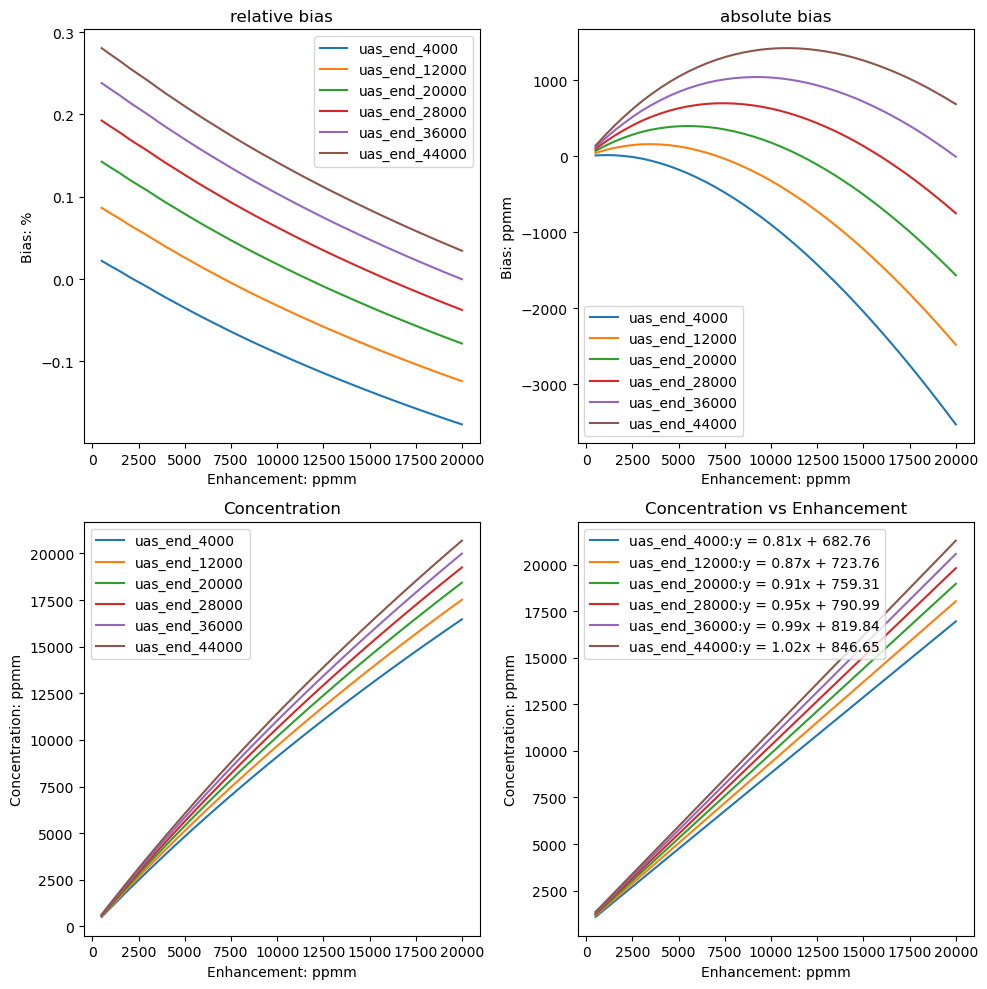

In [86]:
def spectrumlevel_test1():
    """
    测试不同浓度增强下的甲烷廓线直接拟合的浓度结果。 
    使用拟合区间不同的单位吸收光谱。
    """
   
    fig, ax = plt.subplots(2,2,figsize=(10,10))
    ax1,ax2,ax3,ax4 = ax.flatten()
    for end in range(4000,45000,8000):
        # 读取单位吸收光谱 UAS
        ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_{end}.txt"
        _,uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
        
        # 初始化变量
        base = None
        channels_path=r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
        base_filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
        _,base = nf.get_simulated_satellite_radiance(base_filepath,channels_path,2150,2500)
        concentration = 0
        concentrationlist = []
        re_biaslists = []
        ab_biaslists = []
        # 拟合甲烷浓度增强
        enhancements = np.arange(500,20500,500)
        for enhancement in enhancements:
            # 读取模拟辐射数据
            filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_{int(enhancement)}_ppmm_tape7.txt"
            _,radiance = nf.get_simulated_satellite_radiance(filepath,channels_path,2150,2500)
            # 通过直接拟合的方法计算甲烷浓度增强，并计算与实际值的偏差
            concentration = profile_matched_filter(base,radiance,uas)
            ab_biaslists.append(concentration-enhancement)
            re_biaslists.append(((concentration-enhancement)/enhancement))
            concentrationlist.append(concentration)

        ax1.plot(enhancements,re_biaslists,label=f"uas_end_{end}")
        ax2.plot(enhancements,ab_biaslists,label=f"uas_end_{end}")
        ax3.plot(enhancements,concentrationlist,label=f"uas_end_{end}")
        polyfit_plot(enhancements,concentrationlist,ax4,f"uas_end_{end}")
    
    set_plot_details(ax1,"relative bias","Enhancement: ppmm","Bias: %")
    set_plot_details(ax2,"absolute bias","Enhancement: ppmm","Bias: ppmm")
    set_plot_details(ax3,"Concentration","Enhancement: ppmm","Concentration: ppmm")
    set_plot_details(ax4,"Concentration vs Enhancement","Enhancement: ppmm","Concentration: ppmm")

    plt.tight_layout()
    plt.show()
    
    return re_biaslists,ab_biaslists

re_biaslists,ab_biaslists = spectrumlevel_test1()


### 多层单位吸收光谱拟合

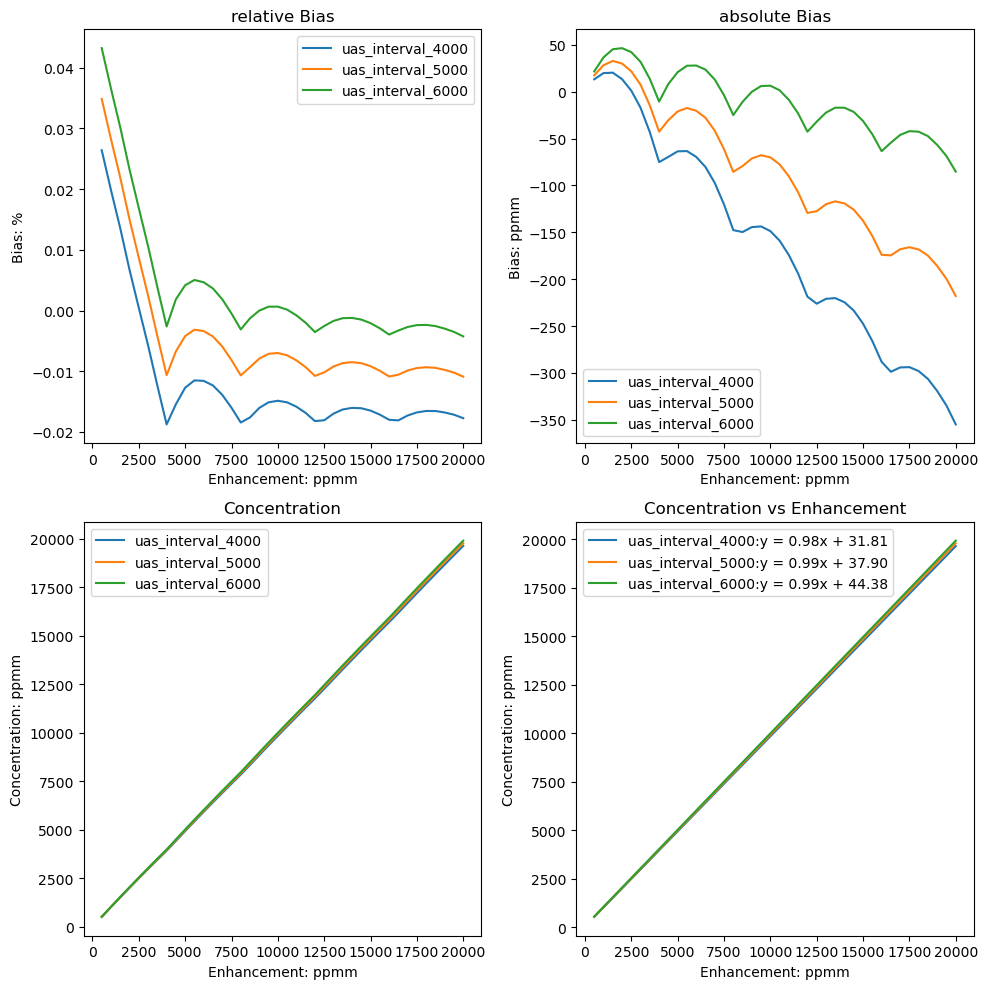

In [96]:
def spectrumlevel_test2():
    """
    测试不同浓度增强下的甲烷廓线拟合的浓度结果,使用多级单位吸收光谱。
    并与单级单位吸收光谱的结果进行对比。
    """ 
    # 可视化
    fig, ax = plt.subplots(2,2,figsize=(10,10))
    ax1,ax2,ax3,ax4 = ax[0,0],ax[0,1],ax[1,0],ax[1,1]
    for interval in range(4000,7000,1000):
        # 读取多级单位吸收光谱,并存储在列表中
        uaslist = []
        uasrange = np.arange(0,46000,4000)
        for i in uasrange:
            # ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_{i}.txt"
            # _,uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
            _,uas = gu.generate_range_uas_AHSI(i,i+interval,2150,2500)
            uaslist.append(uas)
        
        # 读取背景光谱
        channels_path=r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
        base_filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
        _,base_radiance = nf.get_simulated_satellite_radiance(base_filepath,channels_path,2150,2500)
        
        ml_concentrationlist = []
        ml_biaslists = []
        ml_difflists = []
        
        # 拟合甲烷浓度增强
        enhancements = np.arange(500,20500,500)
        for enhancement in enhancements:
            # 读取模拟辐射数据
            filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_{enhancement}_ppmm_tape7.txt"
            _,radiance = nf.get_simulated_satellite_radiance(filepath,channels_path,2150,2500)
        
            concentration = profile_matched_filter_ML(base_radiance,radiance,uaslist)
            ml_biaslists.append(((concentration-enhancement)/enhancement))
            ml_difflists.append(concentration-enhancement)
            ml_concentrationlist.append(concentration)
        
        ax1.plot(enhancements,ml_biaslists,label=f"uas_interval_{interval}")
        ax2.plot(enhancements,ml_difflists,label=f"uas_interval_{interval}")
        ax3.plot(enhancements,ml_concentrationlist,label=f"uas_interval_{interval}")
        polyfit_plot(enhancements,ml_concentrationlist,ax4,f"uas_interval_{interval}")

    set_plot_details(ax1, "relative Bias", "Enhancement: ppmm", "Bias: %")
    set_plot_details(ax2, "absolute Bias", "Enhancement: ppmm", "Bias: ppmm")
    set_plot_details(ax3, "Concentration", "Enhancement: ppmm", "Concentration: ppmm")
    set_plot_details(ax4, "Concentration vs Enhancement", "Enhancement: ppmm", "Concentration: ppmm")
    
    plt.tight_layout()
    plt.show()
    
    return ml_biaslists,ml_difflists

ml_biaslists,ml_difflists = spectrumlevel_test2()


### 两种方式进行对比
选出最佳的参数对前两种方式中进行对比

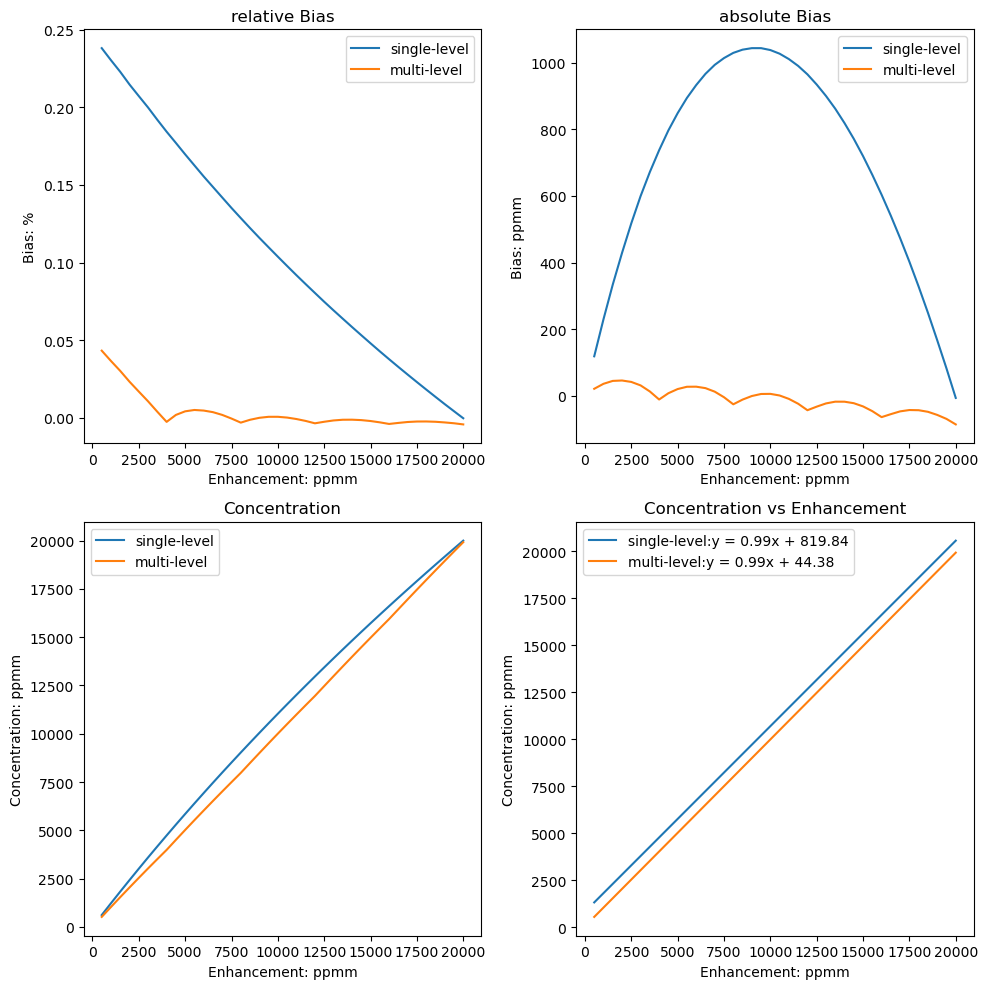

In [97]:

def spectrumlevel_test3():
    """
    测试不同浓度增强下的甲烷廓线拟合的浓度结果,使用多级单位吸收光谱。
    并与单级单位吸收光谱的结果进行对比。
    """
    # 读取单层单位吸收光谱    
    ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_36000.txt"
    _,base_uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
    
    # 读取多级单位吸收光谱,并存储在列表中
    uaslist = []
    uasrange = np.arange(0,46000,4000)
    for i in uasrange:
        # ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_{i}.txt"
        # _,uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
        _,uas = gu.generate_range_uas_AHSI(i,i+6000,2150,2500)
        uaslist.append(uas)
    
    # 读取背景光谱
    channels_path=r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
    base_filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
    _,base_radiance = nf.get_simulated_satellite_radiance(base_filepath,channels_path,2150,2500)
    
    # initiatate variables
    sg_concentrationlist = []
    sg_biaslists = []
    sg_difflists = []
    
    ml_concentrationlist = []
    ml_biaslists = []
    ml_difflists = []
    
    # 拟合甲烷浓度增强
    enhancements = np.arange(500,20500,500)
    for enhancement in enhancements:
        # 读取模拟辐射数据
        filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_{enhancement}_ppmm_tape7.txt"
        _,radiance = nf.get_simulated_satellite_radiance(filepath,channels_path,2150,2500)
    
        # 计算甲烷浓度增强，并计算与实际值的偏差
        concentration = profile_matched_filter(base_radiance,radiance,base_uas)
        sg_biaslists.append(((concentration-enhancement)/enhancement))
        sg_difflists.append(concentration-enhancement)
        sg_concentrationlist.append(concentration)
        
        concentration = profile_matched_filter_ML(base_radiance,radiance,uaslist)
        ml_biaslists.append(((concentration-enhancement)/enhancement))
        ml_difflists.append(concentration-enhancement)
        ml_concentrationlist.append(concentration)
        
    # 可视化
    fig, ax = plt.subplots(2,2,figsize=(10,10))
    ax1,ax2,ax3,ax4 = ax[0,0],ax[0,1],ax[1,0],ax[1,1]
    
    ax1.plot(enhancements,sg_biaslists,label="single-level")
    ax1.plot(enhancements,ml_biaslists,label="multi-level")
    ax2.plot(enhancements,sg_difflists,label="single-level")
    ax2.plot(enhancements,ml_difflists,label="multi-level")
    ax3.plot(enhancements,sg_concentrationlist,label="single-level")
    ax3.plot(enhancements,ml_concentrationlist,label="multi-level")
    polyfit_plot(enhancements,sg_concentrationlist,ax4,"single-level")
    polyfit_plot(enhancements,ml_concentrationlist,ax4,"multi-level")
    
    set_plot_details(ax1, "relative Bias", "Enhancement: ppmm", "Bias: %")
    set_plot_details(ax2, "absolute Bias", "Enhancement: ppmm", "Bias: ppmm")
    set_plot_details(ax3, "Concentration", "Enhancement: ppmm", "Concentration: ppmm")
    set_plot_details(ax4, "Concentration vs Enhancement", "Enhancement: ppmm", "Concentration: ppmm")
    
    plt.tight_layout()
    plt.show()
    
    return sg_biaslists,ml_biaslists

ml_biaslists,sg_biaslists = spectrumlevel_test3()

## 模拟影像测试_1(背景光谱已知)
此测试针对 受到 统一浓度的随机 2% 像素的甲烷浓度增强的模拟影像，背景光谱已知，使用不同的匹配滤波算法
进行浓度的反演，并对结果进行一定的统计。

### 常规匹配滤波算法

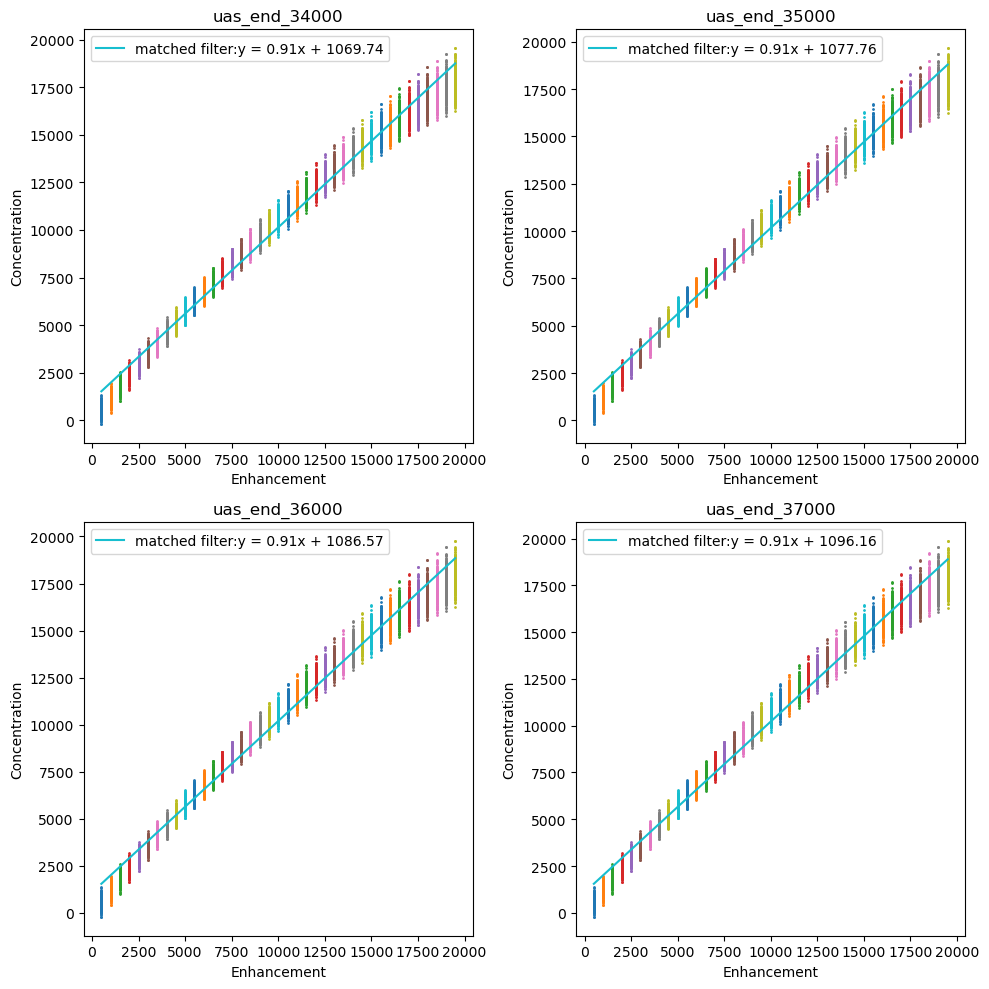

In [99]:
def imagelevel_test2_1():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱已知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    fig,ax = plt.subplots(2,2,figsize=(10,10))
    axf = ax.flatten()
    i = 0
    for end in range(34000,38000,1000):
        # 读取 AHSI 单位吸收谱
        ax1 = axf[i]
        _,uas = gu.generate_range_uas_AHSI(0,end,2150,2500)
        
        # 读取背景光谱
        basefilepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
        channels_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
        _,base_radiance = nf.get_simulated_satellite_radiance(basefilepath,channels_path,2150,2500)
        
        resultlist = []
        
        enhancements = np.arange(500,20000,500)
        for enhancement in enhancements:
            # 生成2%像素浓度增强的模拟影像
            simulated_image,enhanced_mask,unenhanced_mask = enhancement_2perc(enhancement)
            
            # 使用匹配滤波算法计算浓度增强
            result = matched_filter_with_fixed_bg(base_radiance,simulated_image, uas)
            
            # 计算增强和未增强像素的平均浓度
            enhanced = result[enhanced_mask]
            unenhanced = result[unenhanced_mask]
            resultlist.append(np.mean(enhanced))
            ax1.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
        polyfit_plot(enhancements,resultlist,ax1,"matched filter")
        set_plot_details(ax1, f"uas_end_{end}", "Enhancement", "Concentration")
        i += 1
    plt.tight_layout()
    plt.show()
    
    return None

imagelevel_test2_1()

### 多层匹配滤波算法

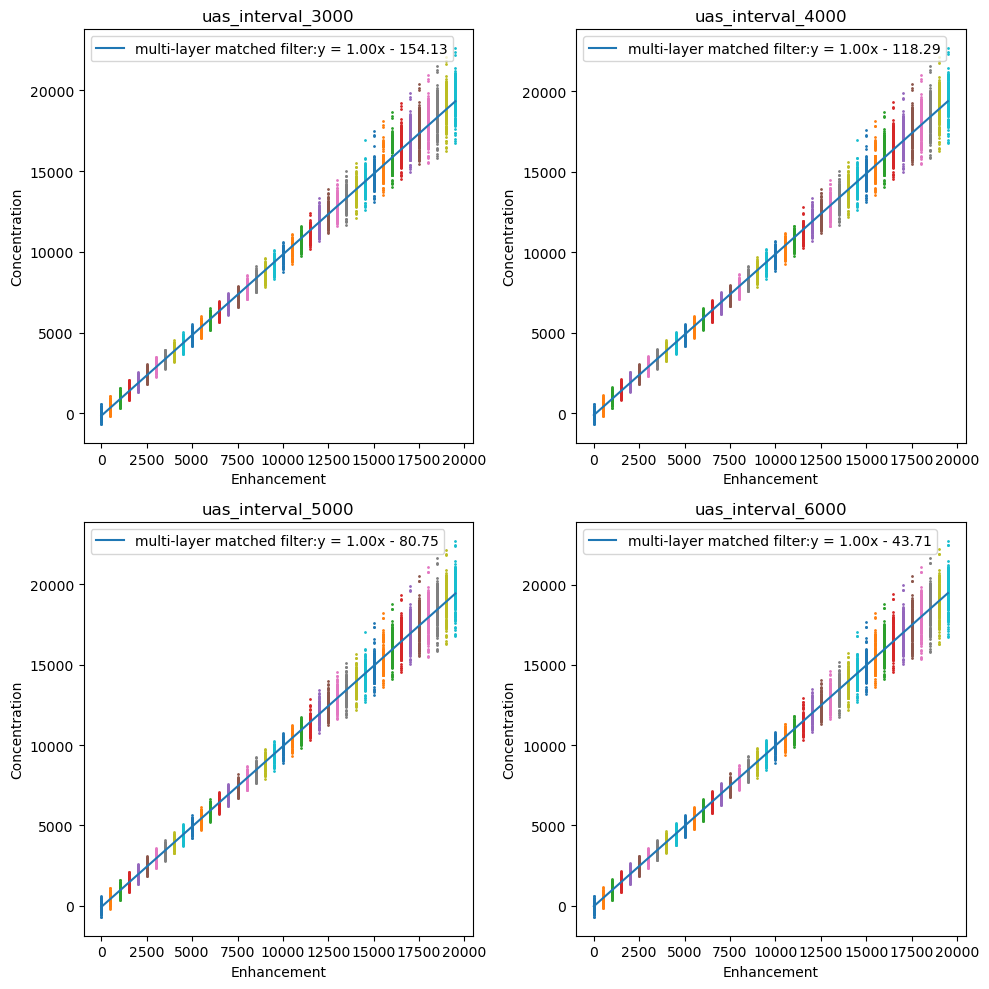

In [106]:
def imagelevel_test2_2():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱已知，使用多层匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    # 读取背景光谱
    basefilepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
    channels_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
    _,base_radiance = nf.get_simulated_satellite_radiance(basefilepath,channels_path,2150,2500)
    
    fig,ax = plt.subplots(2,2,figsize=(10,10))
    axf = ax.flatten()
    axindex = 0
    for interval in range(3000,7000,1000):
        # 读取 AHSI 单位吸收谱
        uaslist = []
        uasrange = np.arange(0,46000,4000)
        for i in uasrange:
            _,uas = gu.generate_range_uas_AHSI(i,i+interval,2150,2500)
            uaslist.append(uas)
        
        enhancements = np.arange(0,20000,500)
        ax1 = axf[axindex]
        resultlist = []
        for enhancement in enhancements:
            simulated_image,enhanced_mask,unenhanced_mask = enhancement_2perc(enhancement)
            # 使用匹配滤波算法计算浓度增强
            result = ML_matched_filter_with_fixed_bg(base_radiance,simulated_image, uaslist)
            enhanced = result[enhanced_mask]
            unenhanced = result[unenhanced_mask]
            resultlist.append(np.mean(enhanced))
            ax1.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
        polyfit_plot(enhancements,resultlist,ax1,"multi-layer matched filter")
        set_plot_details(ax1, f"uas_interval_{interval}", "Enhancement", "Concentration")
        axindex += 1
    plt.tight_layout()
    plt.show()
    
    return resultlist

resultlist = imagelevel_test2_2()


### 两种算法进行对比

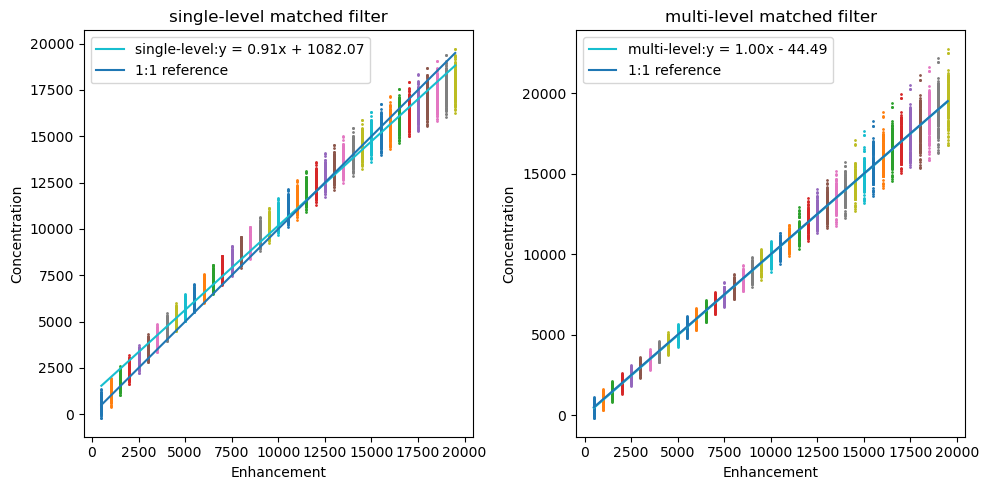

In [111]:
def imagelevel_test2_12():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱已知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    resultlist1 = []
    resultlist2 = []
    
    
    basefilepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
    channels_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
    _,base_radiance = nf.get_simulated_satellite_radiance(basefilepath,channels_path,2150,2500)
    
    # 读取 AHSI 单位吸收谱
    uas_filepath = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_36000.txt"
    _,base_uas = nf.open_unit_absorption_spectrum(uas_filepath,2150,2500)
    
    # 读取多层单位吸收光谱,并存储在列表中
    uaslist = []
    uasrange = np.arange(0,46000,4000)
    for i in uasrange:
        _,uas = gu.generate_range_uas_AHSI(i,i+6000,2150,2500)
        uaslist.append(uas)
    
    
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    enhancements = np.arange(500,20000,500)
    for enhancement in enhancements:
        simulated_image,enhanced_mask,unenhanced_mask = enhancement_2perc(enhancement)
        
        # 使用匹配滤波算法计算浓度增强
        result = matched_filter_with_fixed_bg(base_radiance,simulated_image, base_uas)
        enhanced = result[enhanced_mask]
        unenhanced = result[unenhanced_mask]
        resultlist1.append(np.mean(enhanced))
        ax[0].plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
        # 使用多层单位吸收光谱匹配滤波算法计算浓度增强
        result = ML_matched_filter_with_fixed_bg(base_radiance,simulated_image, uaslist)
        enhanced = result[enhanced_mask]
        unenhanced = result[unenhanced_mask]
        resultlist2.append(np.mean(enhanced))
        ax[1].plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
    polyfit_plot(enhancements,resultlist1,ax[0],"single-level")
    polyfit_plot(enhancements,resultlist2,ax[1],"multi-level")
    ax[0].plot(enhancements,enhancements,label="1:1 reference")
    ax[1].plot(enhancements,enhancements,label="1:1 reference")
    set_plot_details(ax[0], "single-level matched filter", "Enhancement", "Concentration")
    set_plot_details(ax[1], "multi-level matched filter", "Enhancement", "Concentration")
    plt.tight_layout()
    plt.show()
    return resultlist1,resultlist2

resultlist1,resultlist2 = imagelevel_test2_12()

## 模拟影像测试_2(背景光谱未知)
此测试针对 受到 统一浓度的随机 2% 像素的甲烷浓度增强的模拟影像，背景光谱未知，需要近似和不断修正，使用不同的匹配滤波算法
进行浓度的反演，并对结果进行一定的统计。

### 常规匹配滤波算法

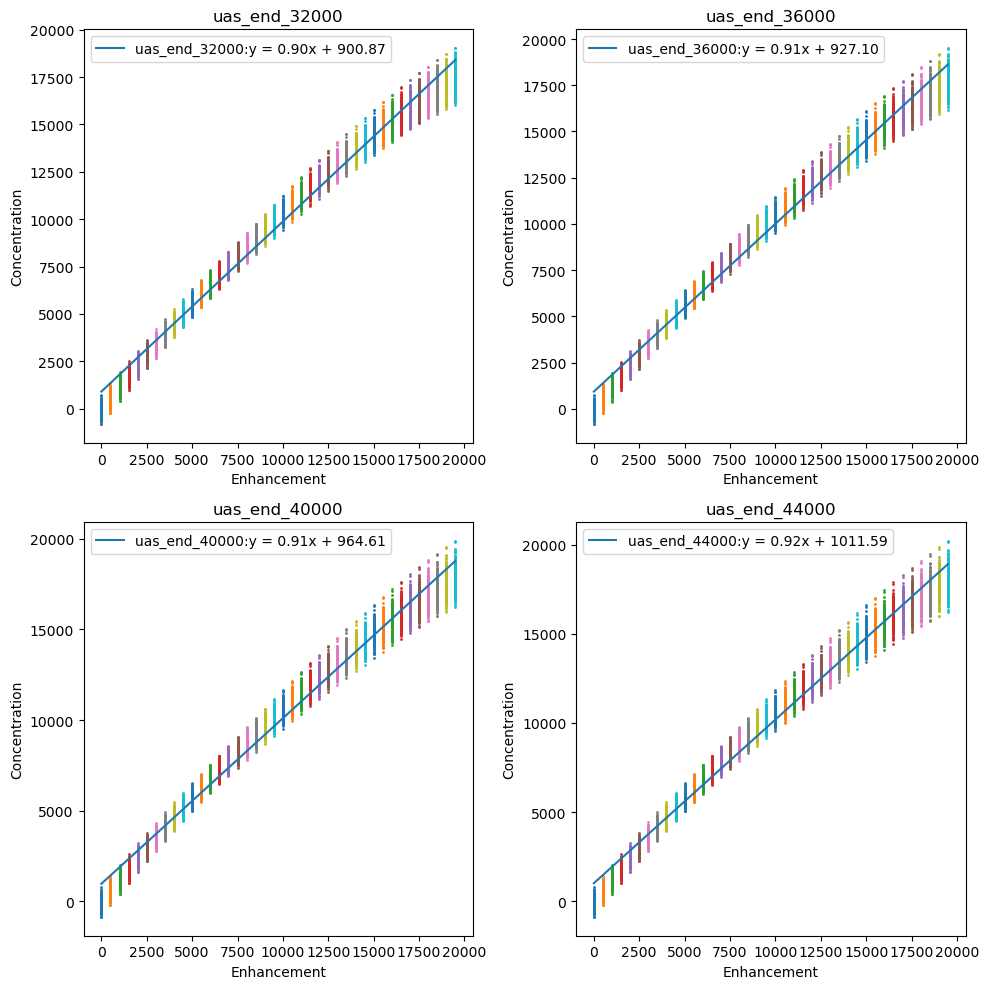

In [112]:
def imagelevel_test2_3():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱未知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    使用不同的单位吸收光谱
    """
    # 读取 AHSI 单位吸收谱
    fig,axes = plt.subplots(2,2,figsize=(10,10))
    axf = axes.flatten()
    axindex = 0
    for end in range(32000,45000,4000):
        ax = axf[axindex]
        # 读取单位吸收光谱
        uas_filepath = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_{end}.txt"
        _,uas = nf.open_unit_absorption_spectrum(uas_filepath,2150,2500)
        
        enhancements = np.arange(0,20000,500)
        resultlist = []
        for enhancement in enhancements:
            simulated_image,enhanced_mask,unenhanced_mask = enhancement_2perc(enhancement)
            result = mf.matched_filter(simulated_image, uas, iterate = False, albedoadjust=False, sparsity= False)
            enhanced = result[enhanced_mask]
            unenhanced = result[unenhanced_mask]
            resultlist.append(np.mean(enhanced))
            ax.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        polyfit_plot(enhancements,resultlist,ax,f"uas_end_{end}")
    
        set_plot_details(ax, f"uas_end_{end}", "Enhancement", "Concentration")
        axindex += 1
    
    plt.tight_layout()
    plt.show()
    
    return resultlist
    
resultlist = imagelevel_test2_3()

### 多层匹配滤波算法

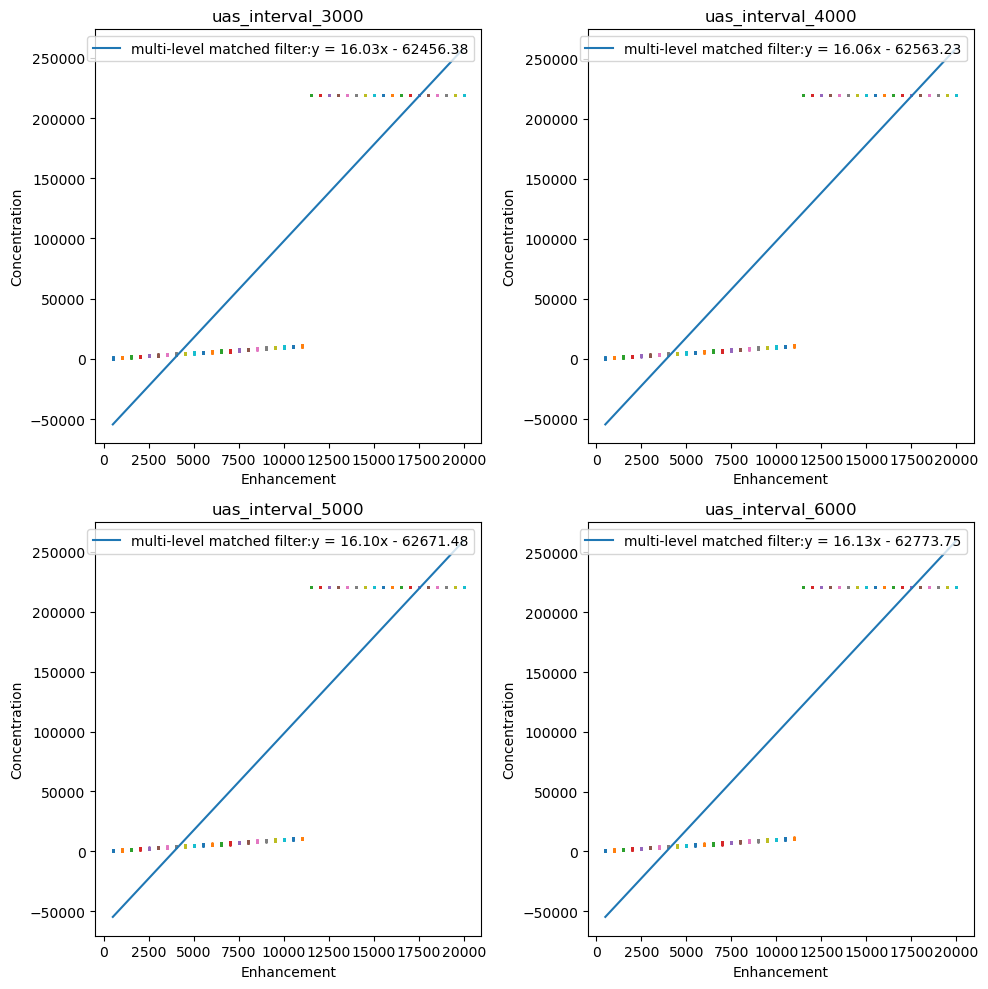

In [113]:
def imagelevel_test2_4():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱未知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    fig,axes = plt.subplots(2,2,figsize=(10,10))
    axf = axes.flatten()
    axindex = 0
    for interval in range(3000,7000,1000):
        ax = axf[axindex]
        # 读取单位吸收光谱列表
        uaslist = []
        uasrange = np.arange(0,46000,6000)
        for i in uasrange:
            _,uas = gu.generate_range_uas_AHSI(i,i+interval,2150,2500)
            uaslist.append(uas)
        
        enhancements = np.arange(500,20500,500)
        resultlist = []
        for enhancement in enhancements:
            simulated_image,enhanced_mask,unenhanced_mask = enhancement_2perc(enhancement)
            result,_ = mf.modified_matched_filter(simulated_image, uaslist)
            
            enhanced = result[enhanced_mask]
            unenhanced = result[unenhanced_mask]
            resultlist.append(np.mean(enhanced))
            ax.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        polyfit_plot(enhancements,resultlist,ax,"multi-level matched filter")
        set_plot_details(ax, f"uas_interval_{interval}", "Enhancement", "Concentration")
        axindex += 1
    
    plt.tight_layout()
    plt.show()
    return resultlist
    
resultlist = imagelevel_test2_4()

### 两种算法对比
基于前两个测试的最佳参数，对两者的反演结果进行对比。

当前浓度增强为：0
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：500
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：1000
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：1500
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：2000
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：2500
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：3000
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：3500
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：4000
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：4500
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
当前浓度增强为：5000
iteration: 

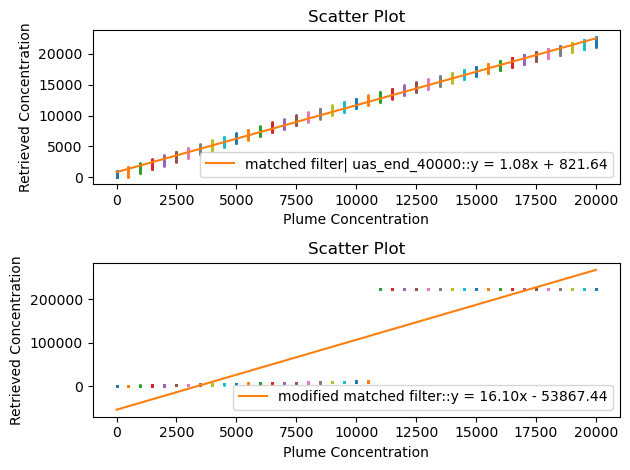

In [48]:
def imagelevel_test2_34():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强的反演结果
    背景光谱未知，使用多层的单位吸收光谱
    并拟合出浓度增强与实际浓度增强的关系，
    """
    # 读取背景光谱
    uas_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_36000.txt"
    _,general_uas = nf.open_unit_absorption_spectrum(uas_path,2150,2500)
    
    # 读取多层单位吸收光谱,并存储在列表中
    uaslist = []
    uasrange = np.arange(4000,46000,6000)
    np.insert(uasrange,0,0)
    for i in uasrange:
        ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_{i}_{i+6000}.txt"
        _,uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
        uaslist.append(uas)
    
    # 可视化
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ax1,ax2 = ax[0],ax[1]
    
    # 生成不同浓度增强的模拟影像，并计算浓度增强
    enhancements = np.arange(0,20500,500)
    resultlist = []
    resultlist2 = []
    for enhancement in enhancements:
        simulated_image,enhanced_mask,unenhanced_mask = enhancement_2perc(enhancement)
        
        # 使用匹配滤波算法计算浓度增强
        result = mf.matched_filter(simulated_image, general_uas, iterate = True, albedoadjust=True, sparsity= False)
        enhanced = result[enhanced_mask]
        resultlist.append(np.mean(enhanced))
        ax1.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
        result,_ = mf.modified_matched_filter(simulated_image, uaslist)
        enhanced = result[enhanced_mask]
        resultlist2.append(np.mean(enhanced))
        ax2.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
    # 创建一个新的 x 值数组用于绘制拟合直线
    polyfit_plot(enhancements,resultlist,ax1,"matched filter | uas_end_36000")
    polyfit_plot(enhancements,resultlist2,ax2,"modified matched filter")
    
    set_plot_details(ax1, "matched filter | uas_end_36000", "Enhancement", "Concentration")
    set_plot_details(ax2, "modified matched filter", "Enhancement", "Concentration")
    
    plt.tight_layout()
    plt.show()
    return resultlist,resultlist2

resultlist1,resultlist2 = imagelevel_test2_34()

## 模拟影像测试_3(高斯烟羽)
此测试针对 叠加了高斯烟羽甲烷浓度增强分布的模拟影像，背景光谱未知，需要通过近似和修正来贴近真实背景光谱
使用不同的匹配滤波算法进行浓度的反演，并对结果进行一定的统计。

### 常规匹配滤波算法

C:\Users\RS\AppData\Local\Temp\ipykernel_36536\3014382712.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(endpoints))


iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5


C:\Users\RS\AppData\Local\Temp\ipykernel_36536\3014382712.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(plume[total_mask],enhancement[total_mask],c= colors[idx],alpha=0.5)


iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5
iteration: No. 1
iteration: No. 2
iteration: No. 3
iteration: No. 4
iteration: No. 5


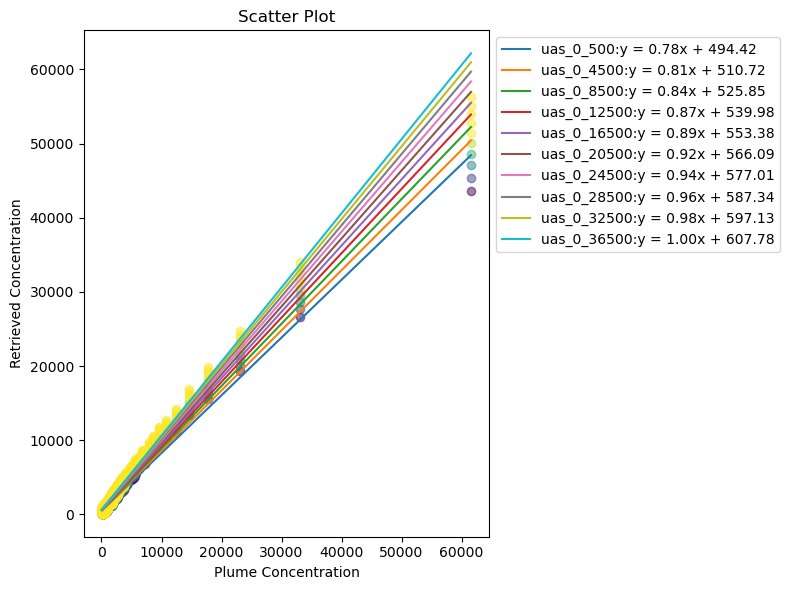

In [51]:
def imagelevel_test3_1():
    """ 
    对叠加了高斯扩散模型的甲烷烟羽模拟影像进行浓度反演
    """
    plume_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\plumes\\gaussianplume_1000_2_stability_D.npy"
    plume = np.load(plume_path)
    simulated_image = image_simulation(plume, 2150, 2500, 100, 100, 0.01)       

    endpoints = np.arange(500, 40500, 4000 )
   
    # 设置色带
    colormap = cm.get_cmap('viridis', len(endpoints))
    norm_values = np.clip((endpoints - 0) / (20000 -0), 0, 1)
    colors = colormap(norm_values)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    for idx, i in enumerate(endpoints):
        # 加载单位吸收谱并生成匹配滤波算法的结果
        _,uas = gu.generate_range_uas_AHSI(0,i,2150,2500)
        enhancement = mf.matched_filter(simulated_image, uas, iterate= True, albedoadjust=True, sparsity= False)
        
        plume_mask = plume > 100
        result_mask = enhancement > 100
        total_mask = plume_mask*result_mask
        
        # 可视化
        ax.scatter(plume[total_mask],enhancement[total_mask],c = colors[idx],alpha=0.5)
        polyfit_plot(plume[total_mask].flatten(),enhancement[total_mask].flatten(),ax,f"uas_0_{i}")
    
        # 对烟羽反演结果进行量化
        molar_mass_CH4 = 16.04  # 甲烷的摩尔质量，g/mol
        molar_volume_STP = 0.0224  # 摩尔体积，m^3/mol at STP
        emission = np.sum(plume[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
        retrieval_emission = np.sum(enhancement[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
        
    # 拟合原始增强和反演结果的关系   
    ax.set_xlabel('Plume Concentration')
    ax.set_ylabel('Retrieved Concentration')
    ax.set_title(f'Scatter Plot')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Add legend outside the plot
    
    plt.tight_layout()
    plt.show()
    
    return None

imagelevel_test3_1()

### 多层匹配滤波算法

current threshold: 6000
current threshold: 12000
current threshold: 18000
current threshold: 24000
current threshold: 30000
current threshold: 36000
0.9806601492015411


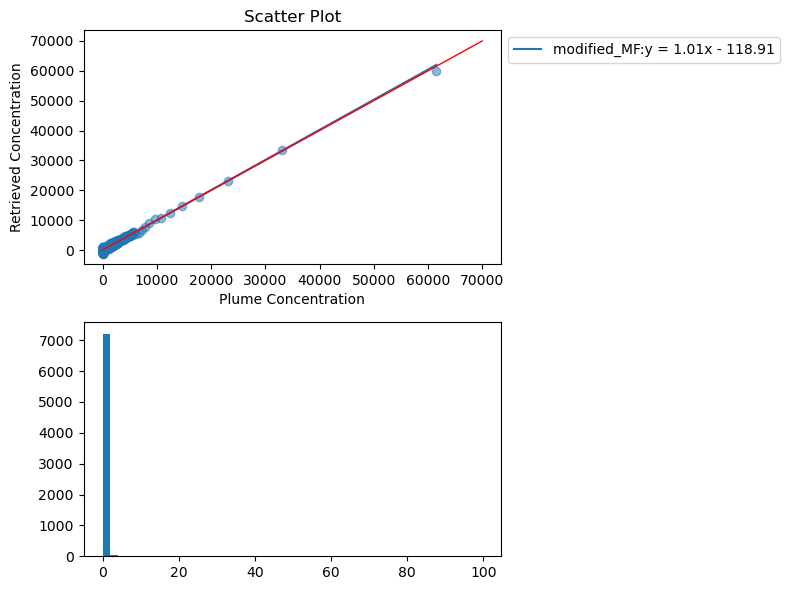

In [55]:
def imagelevel_test3_2():
    """ 
    对叠加了高斯扩散模型的甲烷烟羽模拟影像进行浓度反演
    """
    # 读取烟羽模型
    plume_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\plumes\\gaussianplume_1000_2_stability_D.npy"
    plume = np.load(plume_path)
    simulated_image = image_simulation(plume, 2150, 2500, 100, 100, 0.01)       

    # 读取单位吸收光谱列表
    uaslist = []
    uasrange = np.arange(4000,46000,6000)
    np.insert(uasrange,0,0)
    for i in uasrange:
        _,uas = gu.generate_range_uas_AHSI(i,i+6000,2150,2500)
        uaslist.append(uas)

    endpoints = np.arange(500, 20500, 4000)
    fig, ax = plt.subplots(2,1,figsize=(8, 6))
    # enhancement,_ = mf.modified_matched_filter(simulated_image, uaslist)
    enhancement,_ = mf.modified_matched_filter_backup(simulated_image, uaslist)
    
    plume_mask = plume > 100
    result_mask = enhancement > 100
    total_mask = plume_mask*result_mask
    
    nonplume_mask = plume < 100
    nonresult_mask = enhancement < 100
    bg_mask = nonplume_mask*nonresult_mask
    # 可视化
    ax[0].scatter(plume,enhancement,alpha=0.5)
    polyfit_plot(plume.flatten(),enhancement.flatten(),ax[0],"modified_MF")
    ax[1].hist(plume[bg_mask].flatten(), bins=50)
    # 对烟羽反演结果进行量化
    molar_mass_CH4 = 16.04  # 甲烷的摩尔质量，g/mol
    molar_volume_STP = 0.0224  # 摩尔体积，m^3/mol at STP
    emission = np.sum(plume[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
    retrieval_emission = np.sum(enhancement[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
    print(emission/retrieval_emission)
    
    # 拟合原始增强和反演结果的关系   
    ax[0].plot([0, 70000], [0, 70000], color='red', linestyle='-', linewidth=1)
    ax[0].set_xlabel('Plume Concentration')
    ax[0].set_ylabel('Retrieved Concentration')
    ax[0].set_title(f'Scatter Plot')
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Add legend outside the plot
    plt.tight_layout()
    plt.show()
    
    return None

imagelevel_test3_2()

### 两种算法对比

current threshold: 6000
current threshold: 12000
current threshold: 18000
current threshold: 24000
current threshold: 30000
current threshold: 36000
0.9847795463758081


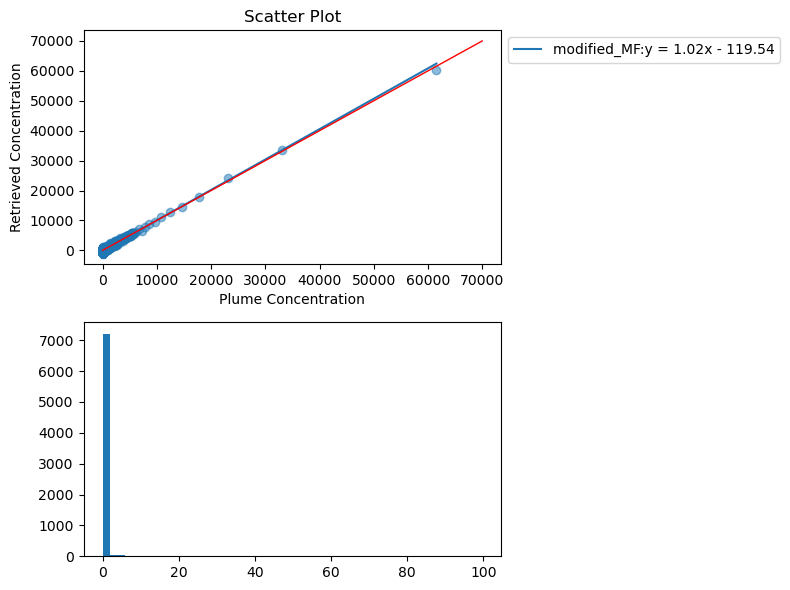

In [57]:
def imagelevel_test3_3():
    """ 
    对叠加了高斯扩散模型的甲烷烟羽模拟影像进行浓度反演
    """
    # 读取烟羽模型
    plume_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\plumes\\gaussianplume_1000_2_stability_D.npy"
    plume = np.load(plume_path)
    simulated_image = image_simulation(plume, 2150, 2500, 100, 100, 0.01)       

    # 读取单位吸收光谱列表
    uaslist = []
    uasrange = np.arange(4000,46000,6000)
    np.insert(uasrange,0,0)
    for i in uasrange:
        _,uas = gu.generate_range_uas_AHSI(i,i+6000,2150,2500)
        uaslist.append(uas)

    endpoints = np.arange(500, 20500, 4000)
    fig, ax = plt.subplots(2,1,figsize=(8, 6))
    # enhancement,_ = mf.modified_matched_filter(simulated_image, uaslist)
    enhancement,_ = mf.modified_matched_filter_backup(simulated_image, uaslist)
    
    plume_mask = plume > 100
    result_mask = enhancement > 100
    total_mask = plume_mask*result_mask
    
    nonplume_mask = plume < 100
    nonresult_mask = enhancement < 100
    bg_mask = nonplume_mask*nonresult_mask
    # 可视化
    ax[0].scatter(plume,enhancement,alpha=0.5)
    polyfit_plot(plume.flatten(),enhancement.flatten(),ax[0],"modified_MF")
    ax[1].hist(plume[bg_mask].flatten(), bins=50)
    # 对烟羽反演结果进行量化
    molar_mass_CH4 = 16.04  # 甲烷的摩尔质量，g/mol
    molar_volume_STP = 0.0224  # 摩尔体积，m^3/mol at STP
    emission = np.sum(plume[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
    retrieval_emission = np.sum(enhancement[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
    print(emission/retrieval_emission)
    
    # 拟合原始增强和反演结果的关系   
    ax[0].plot([0, 70000], [0, 70000], color='red', linestyle='-', linewidth=1)
    ax[0].set_xlabel('Plume Concentration')
    ax[0].set_ylabel('Retrieved Concentration')
    ax[0].set_title(f'Scatter Plot')
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Add legend outside the plot
    plt.tight_layout()
    plt.show()
    
    return None

imagelevel_test3_3()